# Rede neural com camadas escondidas - Classificação do Iris dataset

O objetivo desse experimento é ilustrar o uso de rede neural que tenha mais de uma camada. Isso é conseguido com a inserção de uma ativação não linear entre as camadas.

Datasets utilizados:
    - Iris - 3 classes
    - Sintéticos:
        - meia luas
        - círculos circunscritos
        - blobs

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/Net2RegressaoSoftmaxArgmaxRede.png)

## Importando as bibliotecas

In [1]:
%matplotlib inline
from sklearn import datasets
from IPython import display
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
from torch.autograd import Variable
import torch.nn as nn

## Leitura, normalização e visualização dos dados

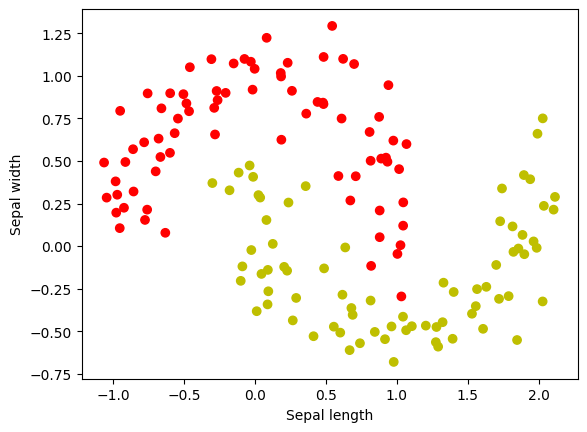

In [2]:
n_samples = 150
options = ['iris', 'moon', 'circles', 'blobs']
option = options[1]
if option == 'iris':
    iris = datasets.load_iris()
    X = iris.data[:,:2]  # comprimento das sépalas e pétalas, indices 0 e 2
    Xc = X - X.min(axis=0)
    Xc /= Xc.max(axis=0)
    Y = iris.target
elif option == 'moon':
    Xc,Y = datasets.make_moons(n_samples=n_samples, noise=.15)
elif option == 'circles':
    Xc,Y = datasets.make_circles(n_samples=n_samples, factor=.5, noise=.1)
elif option == 'blobs':
    Xc,Y = datasets.make_blobs(n_samples=n_samples,centers=3,cluster_std=1.2)

colors = np.array(['r','y','b'])
plt.scatter(Xc[:, 0], Xc[:, 1], c=colors[Y])
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.show()

### Prepara os dados para o PyTorch

In [3]:
X_tensor = torch.FloatTensor(Xc)
Y_tensor = torch.LongTensor(Y)

## Construindo o modelo da rede

In [4]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.ReLU(),
            nn.Linear(5, 5),
            nn.ReLU(),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): ReLU()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): ReLU()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


## _predict_ utilizada para predição de classes e na visualização

In [5]:
def predict(model, inputs):
    outputs = model(Variable(inputs))
    _, predicts = torch.max(outputs, 1)

    return predicts.data.numpy()

## Classe para visualização dinâmica

In [6]:
class BoundaryPlotter():
    def __init__(self, model, X, Y, n_epoch, filepath=None, h = .01):
        self.model = model
        self.X = X
        self.Y = Y
        self.n_epoch = n_epoch
        self.filepath = filepath
        x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
        y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
        self.xx, self.yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        self.loss_hist = []
        self.val_loss_hist = []
        self.X_grid = np.c_[self.xx.ravel(), self.yy.ravel()]

        #Gráficos a serem mostrados pelo callback
        self.fig = plt.figure(figsize=(8, 4), dpi=100)
        self.ax1 = self.fig.add_subplot(1, 2, 1)
        self.ax1.set_xlim(0, nb_epoch)
        self.ax1.set_xlabel('Epoca')#,fontsize=28)
        self.ax1.set_ylabel('Perda')#,fontsize=28)
        self.ax1.plot([],[],'b',linewidth = 2.0,label = "Treino")
        self.ax1.grid(True)

        self.ax2 = self.fig.add_subplot(1, 2, 2)
        self.ax2.set_xlim(Xc[:,0].min(), Xc[:,0].max())
        self.ax2.set_ylim(Xc[:,1].min(), Xc[:,1].max())
        self.ax2.set_xlabel('Comprimento da Sepala')#,fontsize=28)
        self.ax2.set_ylabel('Largura da Sepala')#,fontsize=28)

    def on_train_begin(self, logs={}):
        display.display(self.fig)
        display.clear_output(wait=True)

    def on_epoch_end(self, epoch, logs={}):
        if 'loss' in logs.keys():
            self.loss_hist.append(logs['loss'])

            if epoch%250==0:
                self.ax1.plot(np.arange(epoch+1), self.loss_hist, 'b', linewidth = 2.0)

                Z = predict(self.model, torch.from_numpy(self.X_grid).type(torch.FloatTensor))
#                 Z = torch.max(self.model(Variable(torch.FloatTensor(self.X_grid))).data, dim=1)[1].numpy()
                Z = Z.reshape(self.xx.shape)

                self.ax2.pcolormesh(self.xx, self.yy, Z, cmap=plt.cm.Paired)
                colors = np.array(['r','y','b'])
                self.ax2.scatter(self.X[:, 0], self.X[:, 1], s=40, c=colors[self.Y], edgecolors='k', cmap=plt.cm.Paired)

                display.display(self.fig)
                display.clear_output(wait=True)

## Treinamento

In [7]:
lr = 0.15

optimizer = torch.optim.SGD(model.parameters(), lr=lr)

criterion = nn.CrossEntropyLoss()

### Laço principal de treinamento

Final loss: tensor(0.0267)


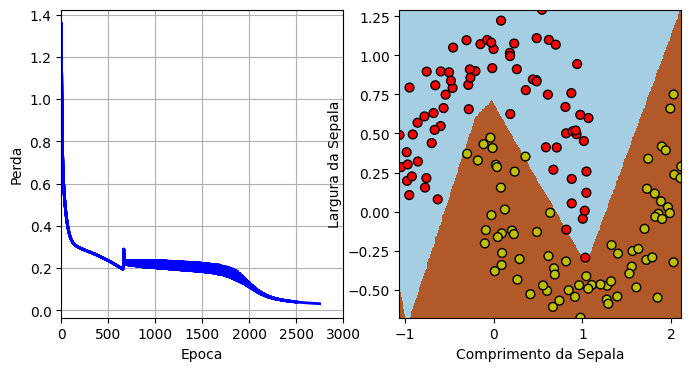

In [8]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

## Avaliação

### Imprimindo pesos finais

In [9]:
for name, w in model.state_dict().items():
    print('{:16}{}'.format(name, w.size()))
    print(w)

dense.0.weight  torch.Size([5, 2])
tensor([[-2.4161, -0.8785],
        [ 1.8387,  0.2822],
        [ 2.1021, -0.4234],
        [ 0.6875, -0.2217],
        [-0.0416, -0.4851]])
dense.0.bias    torch.Size([5])
tensor([ 2.2353,  0.2778,  1.7327,  0.4819, -0.3977])
dense.2.weight  torch.Size([5, 5])
tensor([[ 1.8284,  0.0221, -1.7945, -0.1714,  0.0523],
        [ 1.7016, -0.7607,  1.3934,  0.2046,  0.0955],
        [ 0.0054,  0.0177,  0.1214, -0.4903,  0.0890],
        [ 1.8160, -1.2165,  1.6005,  0.7666, -0.4269],
        [ 0.0978,  0.0510, -0.2828,  0.0727,  0.3472]])
dense.2.bias    torch.Size([5])
tensor([-0.4189, -3.1151,  1.9398, -3.6360, -0.4407])
dense.4.weight  torch.Size([3, 5])
tensor([[ 1.5646, -1.2060,  1.3627, -1.6655, -0.3674],
        [-2.0014,  2.1010, -0.1460,  2.1879, -0.1506],
        [-0.3436, -0.5442, -1.1308, -0.6586,  0.3436]])
dense.4.bias    torch.Size([3])
tensor([ 3.6218, -2.2952, -1.1052])


### Avaliação do classificador

In [10]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.9933333333333333


### Matriz de confusão

In [11]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,74,0
1,1,75


## Atividades

### Experimentos:

1. Faça alterações na rede, alterando o número de neurônios, de camadas. Escreva suas conclusões.
2. No lugar da ReLU, coloque Sigmoid e observe a diferença. O que aconteceu? Descreva.
3. O que ocorre quando não se utiliza ativação não linear entre camadas?

## Principais aprendizados

## Experimento 1: Alterando a rede




In [12]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 10), # Increased neurons from 5 to 10
            nn.ReLU(),
            nn.Linear(10, 10), # Increased neurons from 5 to 10
            nn.ReLU(),
            nn.Linear(10,3), # Input from 10, Output 3
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)


Final loss: tensor(1.2468)


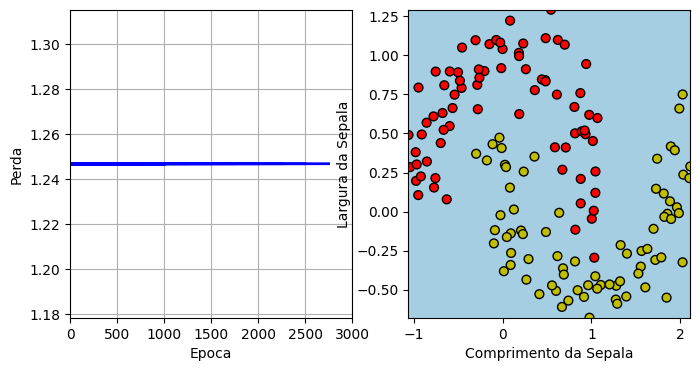

In [13]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

##Avaliando a performance


In [24]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.3466666666666667


##Matriz de confusão


In [26]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,51,52
1,0,1
2,24,22


## Experimento 2: Trocando ReLU por Sigmoid



In [16]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.Sigmoid(), # Replaced ReLU with Sigmoid
            nn.Linear(5, 5),
            nn.Sigmoid(), # Replaced ReLU with Sigmoid
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=5, out_features=5, bias=True)
    (3): Sigmoid()
    (4): Linear(in_features=5, out_features=3, bias=True)
  )
)


Final loss: tensor(1.2239)


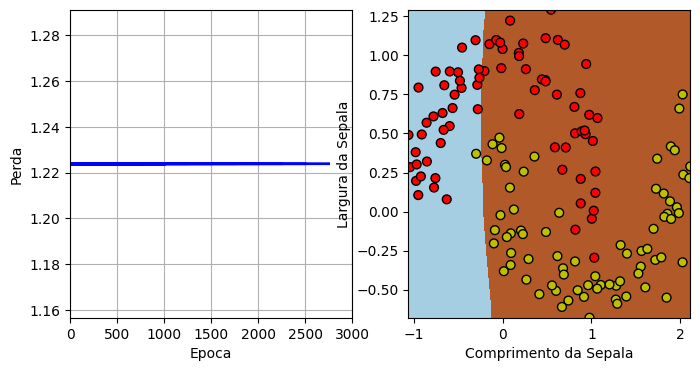

In [17]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

##Avaliando a performance




In [18]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.22


##Matriz de confusão



In [19]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,33,1
2,42,74


## Experimento 3: Tirar a ativação não linear



In [20]:
class Modelo(nn.Module):
    def __init__(self):
        super(Modelo, self).__init__()
        self.dense = nn.Sequential(
            nn.Linear(2, 5),
            nn.Linear(5, 5),
            nn.Linear(5,3),
        )

    def forward(self, x):
        x = self.dense(x)

        return x

model = Modelo()
print(model)

Modelo(
  (dense): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=5, bias=True)
    (2): Linear(in_features=5, out_features=3, bias=True)
  )
)


Final loss: tensor(1.0729)


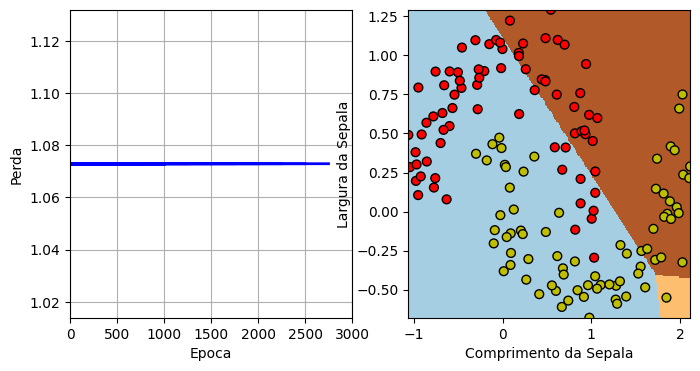

In [21]:
batch_size = 150
nb_epoch = 3000

#Definindo o plotter
boundary_plot = BoundaryPlotter(model, Xc, Y, nb_epoch)

boundary_plot.on_train_begin()
losses = []
for i in range(nb_epoch):
    # predict da rede
    output = model(Variable(X_tensor))

    loss = criterion(output, Variable(Y_tensor))

    # zero, backpropagation gradient, atualiza param gradiente descendente
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.data)

    boundary_plot.on_epoch_end(i, {'loss': loss.data})

print('Final loss:', loss.data)

##Avaliando


In [22]:
Y_hat = predict(model, X_tensor)
accuracy = (Y_hat == Y).mean()
print()
print('Training Accuracy: ', accuracy)


Training Accuracy:  0.3466666666666667


##Matriz de confusão



In [23]:
import pandas as pd
pd.crosstab(Y_hat, Y)

col_0,0,1
row_0,,
0,51,52
1,0,1
2,24,22


##Resumo:

Principais Descobertas da Análise de Dados
Desempenho do Modelo Original (com ReLU e 5 neurônios por camada oculta): Obteve uma perda final baixa de 0.0267 e uma alta acurácia de treinamento de 99.33%, aprendendo efetivamente os limites de decisão não lineares para o conjunto de dados 'moon'.

Experimento 1: Neurônios Aumentados (de 5 para 10 nas camadas ocultas):
Resultou em uma perda final significativamente maior de 1.2468 e uma queda drástica na acurácia de treinamento para 0.0%.
O modelo previu consistentemente uma classe 2 inexistente para todas as amostras, indicando uma falha completa no aprendizado.
Os limites de decisão foram totalmente sem sentido.

Experimento 2: ReLU substituído por Sigmoid:
Levou a uma perda final maior de 1.2239 e uma baixa acurácia de treinamento de 22.0%, uma diminuição substancial em relação ao modelo original.
O modelo ainda previu frequentemente a classe 2 inexistente e lutou para separar as classes reais.
Os limites de decisão foram mal definidos e não conseguiram separar as formas de 'lua'.

Experimento 3: Todas as Ativações Não Lineares Removidas:
Produziu uma perda final de 1.0729 e uma acurácia de treinamento de 34.67%, o melhor entre os três experimentos, mas ainda significativamente pior do que o modelo original.
O modelo teve dificuldades com classificações incorretas e ainda previu a classe 2.
Os limites de decisão foram estritamente lineares, não conseguindo capturar a natureza não linear do conjunto de dados 'moon'.

Notes:

Papel Crucial da Não Linearidade: As funções de ativação não lineares (como ReLU) são essenciais para que as redes neurais aprendam padrões complexos e não lineares. Sua ausência ou substituição por alternativas menos eficazes (como Sigmoid, que sofre de gradientes evanescentes) limita severamente a capacidade do modelo de aprender, mesmo para problemas não lineares relativamente simples.

Arquitetura Ideal para Complexidade do Conjunto de Dados: Para conjuntos de dados como o 'moon', aumentar a complexidade da rede (por exemplo, mais neurônios) além do necessário pode levar à superparametriação, tornando o modelo mais difícil de treinar e menos eficaz se os parâmetros de otimização (como taxa de aprendizado, épocas) não forem ajustados de acordo.